#This Notebook will show training Mobilenetv2 on Pytorch Summary of the notebook

Training has THREE parts Optimization of Hyperparameters using Sequential Model Based Optimization (SMBO). Fitting the Model with the best hyperparameters obtained from optimization. Testing the Model on test set For optimization: Trained with 15 epochs and patient of 3. Total of 300 trials for looking of best hyperparameters combination. For fitting the Model with best hyperparameters: Trained with 100 epochs and patient of 10.

In [1]:
import os
import torch
import time
import random
import hyperopt
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from hyperopt.pyll.stochastic import sample
from torch.utils.data import DataLoader
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from torch.optim import Adam, SGD, RMSprop
from torchvision.models import mobilenet_v2
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#Checking Training machine
!nvidia-smi

Mon Jan 22 10:00:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        On  | 00000000:07:00.0 Off |                  N/A |
|  0%   47C    P8              17W / 170W |      2MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 3. Loading images and Transform

In [8]:
!unzip '/home/g6501222802/thesis/data/opt_data.zip' -d "/home/g6501222802/thesis"

Archive:  /home/g6501222802/thesis/data/opt_data.zip
   creating: /home/g6501222802/thesis/opt_data/
   creating: /home/g6501222802/thesis/opt_data/train/
   creating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_10.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_100.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1007.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1009.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1011.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1015.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1016.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1027.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1029.jpg  
  inflating: /

  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1590.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1603.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1607.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1608.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1610.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1616.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1619.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1622.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_164.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1654.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_1655.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOK

  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_2676.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_2681.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_2683.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_2684.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_2695.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_2697.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_2699.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_2735.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_274.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_276.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_2772.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA

  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_4146.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_415.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_4155.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_4158.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_4160.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_4167.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_4168.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_4171.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_4172.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_4176.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_418.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA

  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_5702.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_571.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_5718.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_5724.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_5729.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_573.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_5737.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_5748.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_575.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_5753.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/Image_576.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/BLACK_SIGATOKA/I

  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (1139).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (1140).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (1144).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (1145).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (1146).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (115).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (1152).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (1160).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (1161).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (1166).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (1169).jpg  
  inflating: /home/g6501222802/thesis/opt_da

  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (2202).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (2204).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (2208).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (2215).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (2216).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (2217).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (2218).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (2219).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (2222).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (2228).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (2233).jpg  
  inflating: /home/g6501222802/thesis/opt_d

  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (3248).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (3251).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (3253).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (3257).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (3268).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (3269).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (3281).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (3287).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (3288).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (3289).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (3292).jpg  
  inflating: /home/g6501222802/thesis/opt_d

  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (777).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (780).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (782).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (789).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (79).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (790).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (793).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (802).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (803).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (804).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FUSARIUM_WILT/Image_ (808).jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/FU

  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_2339.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_2341.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_2348.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_2349.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_235.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_2351.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_2353.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_2355.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_2363.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_2370.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_2375.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_2378.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Imag

  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_3869.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_387.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_3879.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_3894.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_39.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_3904.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_3907.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_3908.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_392.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_3921.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_3939.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_395.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_39

  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_5684.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_569.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_5693.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_5694.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_5700.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_5708.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_5711.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_5716.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_5717.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_5723.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_5731.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Image_5737.jpg  
  inflating: /home/g6501222802/thesis/opt_data/train/HEALTHY/Imag

  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_3951.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_3957.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_3968.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_3975.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_3989.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_4.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_4002.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_4015.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_4016.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_4054.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_4073.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/BLACK_SIGATOKA/Image_4083.jpg  
  infla

  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_428.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_4287.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_4295.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_4296.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_4297.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_43.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_4322.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_4336.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_4351.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_4352.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_4368.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/FUSARIUM_WILT/Image_4383.jpg  
  inflating: /home/

  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_1604.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_162.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_1636.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_1639.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_1641.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_1647.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_1669.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_1670.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_1674.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_1675.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_1684.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_17.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_1739.jpg  
  inflating: /h

  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_3861.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_3863.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_3889.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_3918.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_3925.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_3929.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_3950.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_3958.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_3959.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_3972.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_3985.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_405.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_4114.jpg  
  inflating: 

  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_831.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_850.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_876.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_879.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_944.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_957.jpg  
  inflating: /home/g6501222802/thesis/opt_data/val/HEALTHY/Image_984.jpg  


Resize, Augmentation and Transform

In [10]:
def get_data_loader(batch_size):
    train_transform = transforms.Compose([  #Train set Transform
        transforms.Resize((128, 128)),
        transforms.CenterCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([ #Validation set Transform
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

    #Transform train and validation set
    train_dataset = ImageFolder(root='/home/g6501222802/thesis/opt_data/train', transform=train_transform)
    val_dataset = ImageFolder(root='/home/g6501222802/thesis/opt_data/val', transform=val_transform)

    #Creating Loader
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

 Checking images

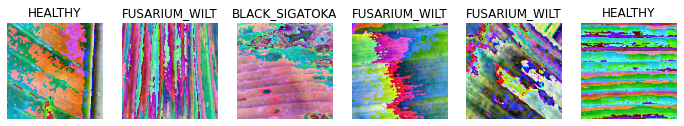

In [11]:
# Print some random images from the dataset
train_transform = transforms.Compose([    # Define data transformations including data augmentation
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
train_dataset = datasets.ImageFolder('/home/g6501222802/thesis/opt_data/train', transform=train_transform)
sample_indices = random.sample(range(len(train_dataset)), 6)
sample_images, sample_labels = zip(*[train_dataset[i] for i in sample_indices])
sample_images = [transforms.functional.to_pil_image(img) for img in sample_images]
sample_labels = [train_dataset.classes[label] for label in sample_labels]

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(np.array(sample_images[i]))
    plt.title(sample_labels[i])
    plt.axis('off')
plt.show()

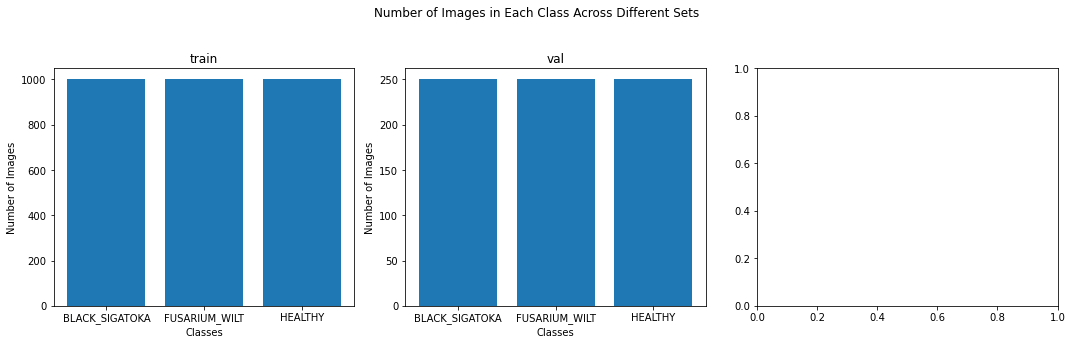

In [15]:
def count_images_in_directory(directory):
    return len([file for file in os.listdir(directory) if file.endswith('.jpg')])

# Main directory path
main_directory_path = '/home/g6501222802/thesis/opt_data'

# Sub-directories
sets = ['train', 'val']
classes = ['BLACK_SIGATOKA', 'FUSARIUM_WILT', 'HEALTHY']

# Dictionary to hold image counts
image_counts = {set_name: {class_name: 0 for class_name in classes} for set_name in sets}

# Counting images in each set and class
for set_name in sets:
    for class_name in classes:
        dir_path = os.path.join(main_directory_path, set_name, class_name)
        image_counts[set_name][class_name] = count_images_in_directory(dir_path)

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Number of Images in Each Class Across Different Sets')

for i, set_name in enumerate(sets):
    counts = [image_counts[set_name][class_name] for class_name in classes]
    axs[i].bar(classes, counts)
    axs[i].set_title(set_name)
    axs[i].set_xlabel('Classes')
    axs[i].set_ylabel('Number of Images')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 4. Optimizing Mobilenetv2-CBAM Hyperparameters with Siquential Model Based optimization(SMBO)

Define early Stopping

In [16]:
# Define call back for early Stopping Callback
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Training

In [17]:
def reset_globals():  #Declaring global varibales for storing loss and accuracy during optimization

    global train_losses, train_accuracies, val_losses, val_accuracies
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

reset_globals()

def objective(params):  #Objective function for optiimizing hyperparameters

    global train_losses, train_accuracies, val_losses, val_accuracies, iteration

    early_stopping = EarlyStopping(patience=5, verbose=True)  #Early stopping

    iteration += 1 # For Tracking iterations

    start_time = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Checking for Cuda
    train_loader, val_loader = get_data_loader(params['batch_size']) #data Loader

  
    #Initialize pre-trained mobilenetv2 module
    model = mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, len(train_loader.dataset.classes))
    model = model.to(device)
    
    

    criterion = nn.CrossEntropyLoss()

    # Optimizer selection
    if params['optimizer'] == 'Adam':
        optimizer = Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'SGD':
        optimizer = SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])
    else:
        optimizer = RMSprop(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])


    epoch_data = [] #Storing number of epochs

    for epoch in range(10): #Training loop

        model.train()
        train_loss =0.0
        train_correct= 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * train_correct / total
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_accuracy)

        model.eval()  #Validation loop
        val_loss =0.0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_accuracy = 100. * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}: Train Acc: {train_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}')
        epoch_data.append([epoch+1, train_accuracy, train_loss, val_accuracy, val_loss])

         # Check for early stopping
        early_stopping(val_losses[-1], model)
        if early_stopping.early_stop:
          print("Early stopping")
          break

    # Load the best model checkpoint
    model.load_state_dict(torch.load('checkpoint.pt'))

    end_time = time.time()
    iteration_duration = end_time - start_time


    return {      #Dictionary to return optimization results and other parameters
        'loss': val_loss,
        'status': STATUS_OK,
        'val_accuracy': val_accuracy,
        'train_accuracy': train_accuracy,
        'train_loss': train_loss,
        'iteration_time': iteration_duration,
        'iterations': iteration,
        'params': params
    }

optimizer_choices = {Adam: 'Adam', SGD: 'SGD', RMSprop: 'RMSprop'}

# call for global variable to count interations
global  iteration

iteration = 0 # Starting count iterations from 0

space = {    #Setting hyperparameters space
    #'lr': hp.uniform('lr', 0.00001, 0.9),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.001)),
    'momentum': hp.uniform('momentum', 0.9, 0.95),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'optimizer': hp.choice('optimizer', [Adam, SGD, RMSprop]),
}

#Run Optimization with 300 trials
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=300, trials=trials)

# Extracting trial data and saving to CSV
results = []
for trial in trials.trials:
    result = trial['result']
    result['params']['optimizer'] = optimizer_choices[result['params']['optimizer']]
    results.append(result)

df = pd.DataFrame(results)
df.to_csv('/home/g6501222802/thesis/results/mobilenetv2_s1_results.csv', index=False) #Save the results to specified file
print("Best parameters found:", best) #Print best Hyperparameters combination obtained


  0%|                                                                 | 0/300 [00:00<?, ?trial/s, best loss=?]

/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(

/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1: Train Acc: 71.00%, Train Loss: 67.6069, Val Acc: 75.47%, Val Loss: 15.5861                           
Validation loss decreased (inf --> 0.649422). Saving model...                                                 
Epoch 2: Train Acc: 82.17%, Train Loss: 44.0212, Val Acc: 74.93%, Val Loss: 11.8139                           
Validation loss decreased (0.649422 --> 0.492245). Saving model...                                            
Epoch 3: Train Acc: 86.87%, Train Loss: 34.2606, Val Acc: 88.67%, Val Loss: 7.2843                            
Validation loss decreased (0.492245 --> 0.303511). Saving model...                                            
Epoch 4: Train Acc: 88.83%, Train Loss: 30.2083, Val Acc: 90.80%, Val Loss: 6.6174                            
Validation loss decreased (0.303511 --> 0.275726). Saving model...                                            
Epoch 5: Train Acc: 89.53%, Train Loss: 25.8828, Val Acc: 89.60%, Val Loss: 7.5867                            
E

Epoch 7: Train Acc: 99.17%, Train Loss: 0.6700, Val Acc: 97.87%, Val Loss: 0.3541                             
Validation loss decreased (0.059828 --> 0.059019). Saving model...                                            
Epoch 8: Train Acc: 99.43%, Train Loss: 0.3481, Val Acc: 98.53%, Val Loss: 0.3999                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 99.53%, Train Loss: 0.4496, Val Acc: 97.60%, Val Loss: 0.5858                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 10: Train Acc: 99.23%, Train Loss: 0.6317, Val Acc: 98.40%, Val Loss: 0.3604                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 1: Train Acc: 90.40%, Train Loss: 25.0496, Val Acc: 96.40%, Val Loss: 2.3923                            
V

EarlyStopping counter: 3 out of 5                                                                             
Epoch 10: Train Acc: 99.63%, Train Loss: 0.4452, Val Acc: 98.40%, Val Loss: 0.4504                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 1: Train Acc: 90.20%, Train Loss: 13.1071, Val Acc: 95.47%, Val Loss: 1.9340                            
Validation loss decreased (inf --> 0.161170). Saving model...                                                 
Epoch 2: Train Acc: 96.63%, Train Loss: 4.5988, Val Acc: 97.20%, Val Loss: 1.4476                             
Validation loss decreased (0.161170 --> 0.120637). Saving model...                                            
Epoch 3: Train Acc: 96.80%, Train Loss: 4.3451, Val Acc: 97.60%, Val Loss: 0.8702                             
Validation loss decreased (0.120637 --> 0.072519). Saving model...                                            
E

EarlyStopping counter: 4 out of 5                                                                             
Epoch 1: Train Acc: 89.33%, Train Loss: 8.2734, Val Acc: 96.00%, Val Loss: 1.4526                             
Validation loss decreased (inf --> 0.242102). Saving model...                                                 
Epoch 2: Train Acc: 97.57%, Train Loss: 1.6510, Val Acc: 98.00%, Val Loss: 0.5481                             
Validation loss decreased (0.242102 --> 0.091358). Saving model...                                            
Epoch 3: Train Acc: 98.53%, Train Loss: 0.9499, Val Acc: 98.13%, Val Loss: 0.3873                             
Validation loss decreased (0.091358 --> 0.064551). Saving model...                                            
Epoch 4: Train Acc: 98.97%, Train Loss: 0.6883, Val Acc: 98.40%, Val Loss: 0.3605                             
Validation loss decreased (0.064551 --> 0.060080). Saving model...                                            
E

Epoch 5: Train Acc: 99.07%, Train Loss: 0.7019, Val Acc: 99.20%, Val Loss: 0.1373                             
Validation loss decreased (0.040545 --> 0.022882). Saving model...                                            
Epoch 6: Train Acc: 99.07%, Train Loss: 0.6708, Val Acc: 98.53%, Val Loss: 0.3185                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 7: Train Acc: 99.37%, Train Loss: 0.5002, Val Acc: 98.13%, Val Loss: 0.2344                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 8: Train Acc: 99.63%, Train Loss: 0.3128, Val Acc: 98.93%, Val Loss: 0.1647                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 9: Train Acc: 99.53%, Train Loss: 0.2761, Val Acc: 98.93%, Val Loss: 0.1860                             
E

Early stopping                                                                                                
Epoch 1: Train Acc: 92.00%, Train Loss: 5.9837, Val Acc: 93.87%, Val Loss: 2.7207                             
Validation loss decreased (inf --> 0.453457). Saving model...                                                 
Epoch 2: Train Acc: 97.27%, Train Loss: 1.8038, Val Acc: 97.20%, Val Loss: 0.5308                             
Validation loss decreased (0.453457 --> 0.088463). Saving model...                                            
Epoch 3: Train Acc: 98.73%, Train Loss: 0.9399, Val Acc: 96.93%, Val Loss: 0.5624                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 4: Train Acc: 98.93%, Train Loss: 0.6964, Val Acc: 98.67%, Val Loss: 0.2263                             
Validation loss decreased (0.088463 --> 0.037721). Saving model...                                            
E

EarlyStopping counter: 2 out of 5                                                                             
Epoch 6: Train Acc: 97.80%, Train Loss: 5.8523, Val Acc: 97.47%, Val Loss: 2.5632                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 7: Train Acc: 98.40%, Train Loss: 4.9835, Val Acc: 98.67%, Val Loss: 0.8511                             
Validation loss decreased (0.047655 --> 0.035461). Saving model...                                            
Epoch 8: Train Acc: 98.10%, Train Loss: 5.1458, Val Acc: 98.27%, Val Loss: 1.6528                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 98.93%, Train Loss: 3.5346, Val Acc: 98.53%, Val Loss: 1.6582                             
EarlyStopping counter: 2 out of 5                                                                             
E

Epoch 2: Train Acc: 97.47%, Train Loss: 3.0331, Val Acc: 98.40%, Val Loss: 0.5348                             
Validation loss decreased (0.065626 --> 0.044568). Saving model...                                            
Epoch 3: Train Acc: 98.90%, Train Loss: 1.5296, Val Acc: 98.53%, Val Loss: 0.3864                             
Validation loss decreased (0.044568 --> 0.032196). Saving model...                                            
Epoch 4: Train Acc: 99.47%, Train Loss: 0.7864, Val Acc: 98.80%, Val Loss: 0.3773                             
Validation loss decreased (0.032196 --> 0.031446). Saving model...                                            
Epoch 5: Train Acc: 99.57%, Train Loss: 0.8550, Val Acc: 98.53%, Val Loss: 0.6030                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 6: Train Acc: 99.00%, Train Loss: 1.5537, Val Acc: 97.87%, Val Loss: 0.6957                             
E

Epoch 6: Train Acc: 99.33%, Train Loss: 0.5052, Val Acc: 98.00%, Val Loss: 0.5569                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 7: Train Acc: 99.03%, Train Loss: 0.9121, Val Acc: 98.40%, Val Loss: 0.2831                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 8: Train Acc: 99.07%, Train Loss: 0.4681, Val Acc: 98.00%, Val Loss: 0.2880                             
EarlyStopping counter: 4 out of 5                                                                             
Epoch 9: Train Acc: 99.53%, Train Loss: 0.3622, Val Acc: 98.27%, Val Loss: 0.3639                             
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
E

Early stopping                                                                                                
Epoch 1: Train Acc: 89.53%, Train Loss: 6.5820, Val Acc: 96.53%, Val Loss: 1.0506                             
Validation loss decreased (inf --> 0.175092). Saving model...                                                 
Epoch 2: Train Acc: 97.77%, Train Loss: 1.6783, Val Acc: 98.27%, Val Loss: 0.2168                             
Validation loss decreased (0.175092 --> 0.036136). Saving model...                                            
Epoch 3: Train Acc: 98.97%, Train Loss: 0.6369, Val Acc: 98.40%, Val Loss: 0.2075                             
Validation loss decreased (0.036136 --> 0.034577). Saving model...                                            
Epoch 4: Train Acc: 99.53%, Train Loss: 0.3428, Val Acc: 98.00%, Val Loss: 0.4382                             
EarlyStopping counter: 1 out of 5                                                                             
E

Epoch 4: Train Acc: 99.57%, Train Loss: 0.3521, Val Acc: 98.27%, Val Loss: 0.2114                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 5: Train Acc: 99.80%, Train Loss: 0.1732, Val Acc: 99.07%, Val Loss: 0.1480                             
Validation loss decreased (0.030130 --> 0.024669). Saving model...                                            
Epoch 6: Train Acc: 99.70%, Train Loss: 0.2146, Val Acc: 98.80%, Val Loss: 0.1936                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 7: Train Acc: 99.47%, Train Loss: 0.3879, Val Acc: 99.07%, Val Loss: 0.1617                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 8: Train Acc: 99.57%, Train Loss: 0.3248, Val Acc: 99.33%, Val Loss: 0.1314                             
V

Validation loss decreased (0.029239 --> 0.020580). Saving model...                                            
Epoch 8: Train Acc: 99.90%, Train Loss: 0.0685, Val Acc: 99.20%, Val Loss: 0.1256                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 99.87%, Train Loss: 0.3056, Val Acc: 98.80%, Val Loss: 0.2067                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 10: Train Acc: 99.83%, Train Loss: 0.1402, Val Acc: 98.67%, Val Loss: 0.2048                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 1: Train Acc: 91.23%, Train Loss: 6.6136, Val Acc: 97.33%, Val Loss: 0.8155                             
Validation loss decreased (inf --> 0.135921). Saving model...                                                 
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 95.30%, Train Loss: 11.9495, Val Acc: 95.60%, Val Loss: 2.7076                           
EarlyStopping counter: 2 out of 5                                                                             
Epoch 1: Train Acc: 64.30%, Train Loss: 20.7890, Val Acc: 33.33%, Val Loss: 6.5979                            
Validation loss decreased (inf --> 1.099652). Saving model...                                                 
Epoch 2: Train Acc: 84.47%, Train Loss: 10.3575, Val Acc: 41.47%, Val Loss: 26.0836                           
EarlyStopping counter: 1 out of 5                                                                             
Epoch 3: Train Acc: 89.80%, Train Loss: 6.7653, Val Acc: 87.07%, Val Loss: 3.1201                             
Validation loss decreased (1.099652 --> 0.520010). Saving model...                                            
E

Validation loss decreased (0.396865 --> 0.219657). Saving model...                                            
Epoch 3: Train Acc: 94.87%, Train Loss: 6.4706, Val Acc: 96.27%, Val Loss: 1.2712                             
Validation loss decreased (0.219657 --> 0.105936). Saving model...                                            
Epoch 4: Train Acc: 96.23%, Train Loss: 5.4854, Val Acc: 95.33%, Val Loss: 1.3809                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 96.03%, Train Loss: 4.9315, Val Acc: 96.93%, Val Loss: 1.2206                             
Validation loss decreased (0.105936 --> 0.101713). Saving model...                                            
Epoch 6: Train Acc: 97.10%, Train Loss: 4.2310, Val Acc: 96.80%, Val Loss: 1.1672                             
Validation loss decreased (0.101713 --> 0.097264). Saving model...                                            
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 6: Train Acc: 98.63%, Train Loss: 0.9459, Val Acc: 98.53%, Val Loss: 0.3840                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 7: Train Acc: 98.93%, Train Loss: 0.7166, Val Acc: 97.87%, Val Loss: 0.2901                             
Validation loss decreased (0.054084 --> 0.048355). Saving model...                                            
Epoch 8: Train Acc: 99.17%, Train Loss: 0.8340, Val Acc: 98.13%, Val Loss: 0.5664                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 9: Train Acc: 98.57%, Train Loss: 1.2047, Val Acc: 97.60%, Val Loss: 0.3752                             
EarlyStopping counter: 2 out of 5                                                                             
E

EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
Epoch 1: Train Acc: 90.37%, Train Loss: 6.4609, Val Acc: 97.20%, Val Loss: 0.7512                             
Validation loss decreased (inf --> 0.125197). Saving model...                                                 
Epoch 2: Train Acc: 98.43%, Train Loss: 0.9937, Val Acc: 98.53%, Val Loss: 0.3577                             
Validation loss decreased (0.125197 --> 0.059617). Saving model...                                            
Epoch 3: Train Acc: 98.53%, Train Loss: 1.0249, Val Acc: 98.40%, Val Loss: 0.1820                             
Validation loss decreased (0.059617 --> 0.030329). Saving model...                                            
Epoch 4: Train Acc: 99.33%, Train Loss: 0.4639, Val Acc: 98.93%, Val Loss: 0.2085                             
E

Validation loss decreased (0.169706 --> 0.124745). Saving model...                                            
Epoch 3: Train Acc: 93.90%, Train Loss: 17.5548, Val Acc: 91.87%, Val Loss: 5.6879                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 4: Train Acc: 95.17%, Train Loss: 13.2892, Val Acc: 93.73%, Val Loss: 3.4409                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 5: Train Acc: 95.80%, Train Loss: 11.4252, Val Acc: 96.93%, Val Loss: 2.0372                            
Validation loss decreased (0.124745 --> 0.084881). Saving model...                                            
Epoch 6: Train Acc: 94.93%, Train Loss: 12.9542, Val Acc: 95.60%, Val Loss: 2.5969                            
EarlyStopping counter: 1 out of 5                                                                             
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 99.57%, Train Loss: 0.2976, Val Acc: 98.40%, Val Loss: 0.2607                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 6: Train Acc: 99.67%, Train Loss: 0.2281, Val Acc: 98.93%, Val Loss: 0.1965                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 7: Train Acc: 99.70%, Train Loss: 0.2005, Val Acc: 99.07%, Val Loss: 0.1797                             
EarlyStopping counter: 4 out of 5                                                                             
Epoch 8: Train Acc: 99.83%, Train Loss: 0.1371, Val Acc: 98.40%, Val Loss: 0.2788                             
EarlyStopping counter: 5 out of 5                                                                             
E

Validation loss decreased (0.041412 --> 0.035047). Saving model...                                            
Epoch 9: Train Acc: 98.83%, Train Loss: 3.1781, Val Acc: 98.00%, Val Loss: 1.4984                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 98.97%, Train Loss: 2.4126, Val Acc: 98.93%, Val Loss: 0.8473                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 1: Train Acc: 89.23%, Train Loss: 7.7082, Val Acc: 97.33%, Val Loss: 0.4591                             
Validation loss decreased (inf --> 0.076509). Saving model...                                                 
Epoch 2: Train Acc: 98.77%, Train Loss: 0.9948, Val Acc: 98.67%, Val Loss: 0.2668                             
Validation loss decreased (0.076509 --> 0.044471). Saving model...                                            
E

Epoch 4: Train Acc: 98.47%, Train Loss: 2.2538, Val Acc: 99.20%, Val Loss: 0.4311                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 99.27%, Train Loss: 1.1677, Val Acc: 99.60%, Val Loss: 0.3039                             
Validation loss decreased (0.027207 --> 0.025325). Saving model...                                            
Epoch 6: Train Acc: 99.23%, Train Loss: 1.3209, Val Acc: 98.67%, Val Loss: 0.4820                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 7: Train Acc: 99.17%, Train Loss: 1.2077, Val Acc: 98.53%, Val Loss: 0.4906                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 8: Train Acc: 98.73%, Train Loss: 1.5472, Val Acc: 98.27%, Val Loss: 0.6448                             
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 7: Train Acc: 99.77%, Train Loss: 0.2247, Val Acc: 98.93%, Val Loss: 0.2617                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 8: Train Acc: 99.83%, Train Loss: 0.1419, Val Acc: 99.20%, Val Loss: 0.1927                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 9: Train Acc: 99.83%, Train Loss: 0.1785, Val Acc: 99.73%, Val Loss: 0.0744                             
Validation loss decreased (0.013531 --> 0.012406). Saving model...                                            
Epoch 10: Train Acc: 99.60%, Train Loss: 0.2864, Val Acc: 99.47%, Val Loss: 0.1082                            
EarlyStopping counter: 1 out of 5                                                                             
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 99.80%, Train Loss: 0.1418, Val Acc: 98.67%, Val Loss: 0.1822                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 1: Train Acc: 91.23%, Train Loss: 5.9260, Val Acc: 95.47%, Val Loss: 1.9420                             
Validation loss decreased (inf --> 0.323665). Saving model...                                                 
Epoch 2: Train Acc: 97.60%, Train Loss: 1.6224, Val Acc: 96.67%, Val Loss: 0.5002                             
Validation loss decreased (0.323665 --> 0.083372). Saving model...                                            
Epoch 3: Train Acc: 99.20%, Train Loss: 0.5418, Val Acc: 98.40%, Val Loss: 0.2337                             
Validation loss decreased (0.083372 --> 0.038953). Saving model...                                            
E

Validation loss decreased (0.025307 --> 0.018999). Saving model...                                            
Epoch 7: Train Acc: 99.67%, Train Loss: 0.2949, Val Acc: 99.07%, Val Loss: 0.1748                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 8: Train Acc: 99.73%, Train Loss: 0.1979, Val Acc: 99.20%, Val Loss: 0.1258                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 9: Train Acc: 99.70%, Train Loss: 0.2021, Val Acc: 98.53%, Val Loss: 0.3678                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 10: Train Acc: 99.57%, Train Loss: 0.4166, Val Acc: 98.93%, Val Loss: 0.1516                            
EarlyStopping counter: 4 out of 5                                                                             
E

Early stopping                                                                                                
Epoch 1: Train Acc: 89.67%, Train Loss: 6.7851, Val Acc: 84.40%, Val Loss: 5.4288                             
Validation loss decreased (inf --> 0.904808). Saving model...                                                 
Epoch 2: Train Acc: 95.07%, Train Loss: 3.7236, Val Acc: 96.13%, Val Loss: 0.8163                             
Validation loss decreased (0.904808 --> 0.136047). Saving model...                                            
Epoch 3: Train Acc: 96.93%, Train Loss: 2.1280, Val Acc: 94.80%, Val Loss: 0.9625                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 4: Train Acc: 97.57%, Train Loss: 1.6003, Val Acc: 97.47%, Val Loss: 0.5383                             
Validation loss decreased (0.136047 --> 0.089714). Saving model...                                            
E

Validation loss decreased (0.076171 --> 0.064206). Saving model...                                            
Epoch 4: Train Acc: 98.87%, Train Loss: 0.9082, Val Acc: 98.27%, Val Loss: 0.3901                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 98.80%, Train Loss: 0.9259, Val Acc: 97.33%, Val Loss: 0.4905                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 6: Train Acc: 98.87%, Train Loss: 0.9208, Val Acc: 97.20%, Val Loss: 0.5110                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 7: Train Acc: 99.33%, Train Loss: 0.3812, Val Acc: 98.13%, Val Loss: 0.5767                             
EarlyStopping counter: 4 out of 5                                                                             
E

Epoch 1: Train Acc: 84.80%, Train Loss: 37.6904, Val Acc: 94.13%, Val Loss: 3.6008                            
Validation loss decreased (inf --> 0.150033). Saving model...                                                 
Epoch 2: Train Acc: 92.33%, Train Loss: 20.2299, Val Acc: 95.33%, Val Loss: 3.7514                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 3: Train Acc: 94.17%, Train Loss: 15.4682, Val Acc: 94.93%, Val Loss: 3.0317                            
Validation loss decreased (0.150033 --> 0.126322). Saving model...                                            
Epoch 4: Train Acc: 94.87%, Train Loss: 14.0408, Val Acc: 88.53%, Val Loss: 7.5865                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 95.03%, Train Loss: 13.1207, Val Acc: 95.33%, Val Loss: 3.2737                            
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 4: Train Acc: 98.17%, Train Loss: 5.6203, Val Acc: 98.67%, Val Loss: 1.0347                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 5: Train Acc: 99.10%, Train Loss: 2.8196, Val Acc: 98.67%, Val Loss: 0.8683                             
EarlyStopping counter: 3 out of 5                                                                             
Epoch 6: Train Acc: 99.00%, Train Loss: 2.5013, Val Acc: 98.67%, Val Loss: 0.9321                             
EarlyStopping counter: 4 out of 5                                                                             
Epoch 7: Train Acc: 98.83%, Train Loss: 3.0607, Val Acc: 98.80%, Val Loss: 1.0508                             
EarlyStopping counter: 5 out of 5                                                                             
E

Epoch 10: Train Acc: 99.27%, Train Loss: 1.8418, Val Acc: 99.33%, Val Loss: 0.6722                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 1: Train Acc: 87.90%, Train Loss: 7.3838, Val Acc: 91.07%, Val Loss: 3.7240                             
Validation loss decreased (inf --> 0.620673). Saving model...                                                 
Epoch 2: Train Acc: 96.73%, Train Loss: 2.2762, Val Acc: 97.47%, Val Loss: 0.4092                             
Validation loss decreased (0.620673 --> 0.068199). Saving model...                                            
Epoch 3: Train Acc: 97.73%, Train Loss: 1.5435, Val Acc: 96.27%, Val Loss: 0.5623                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 4: Train Acc: 98.03%, Train Loss: 1.1984, Val Acc: 97.73%, Val Loss: 0.3907                             
V

Epoch 3: Train Acc: 91.93%, Train Loss: 20.7175, Val Acc: 95.47%, Val Loss: 3.3495                            
Validation loss decreased (0.315613 --> 0.139562). Saving model...                                            
Epoch 4: Train Acc: 93.30%, Train Loss: 16.5694, Val Acc: 92.53%, Val Loss: 5.5505                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 5: Train Acc: 93.60%, Train Loss: 17.9271, Val Acc: 95.07%, Val Loss: 3.1902                            
Validation loss decreased (0.139562 --> 0.132925). Saving model...                                            
Epoch 6: Train Acc: 94.90%, Train Loss: 14.8941, Val Acc: 95.87%, Val Loss: 3.1525                            
Validation loss decreased (0.132925 --> 0.131356). Saving model...                                            
Epoch 7: Train Acc: 94.83%, Train Loss: 14.1400, Val Acc: 95.87%, Val Loss: 3.8095                            
E

Epoch 1: Train Acc: 68.83%, Train Loss: 21.3106, Val Acc: 41.47%, Val Loss: 6.6382                            
Validation loss decreased (inf --> 1.106375). Saving model...                                                 
Epoch 2: Train Acc: 83.60%, Train Loss: 10.7321, Val Acc: 48.13%, Val Loss: 10.3980                           
EarlyStopping counter: 1 out of 5                                                                             
Epoch 3: Train Acc: 88.90%, Train Loss: 7.7569, Val Acc: 87.33%, Val Loss: 2.2330                             
Validation loss decreased (1.106375 --> 0.372172). Saving model...                                            
Epoch 4: Train Acc: 92.20%, Train Loss: 5.3981, Val Acc: 91.47%, Val Loss: 1.3073                             
Validation loss decreased (0.372172 --> 0.217879). Saving model...                                            
Epoch 5: Train Acc: 94.50%, Train Loss: 3.8791, Val Acc: 90.67%, Val Loss: 1.6416                             
E

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 5. Training with best parameters and Testing on Test set

Loading Train and test data

In [7]:
# Define data transformations including data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(244),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Define data paths
train_data_path = '/home/g6501222802/thesis/Data/train'
valid_data_path = '/home/g6501222802/thesis/Data/val/'
test_data_path = '/home/g6501222802/thesis/Data/test/'

In [9]:
# Create data loaders
train_dataset = ImageFolder(train_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

valid_dataset = ImageFolder(valid_data_path, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=2)

test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [10]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.000016, momentum=0.90)

In [11]:
# Define call back for early Stopping Callback
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='/home/g6501222802/thesis/results/mobilenetv2_s1_best_model_checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=10, verbose=True)

In [14]:
best_valid_loss = float('inf') 

# Training loop with early stopping
import time
start_time = time.time()
num_epochs = 100 # Adjust the number of epochs as needed


train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy.append(100 * correct_train / total_train)
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
    valid_accuracy.append(100 * correct_valid / total_valid)
    valid_losses.append(valid_loss / len(valid_loader))

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracy[-1]:.2f}%, "
          f"Valid Loss: {valid_losses[-1]:.4f}, "
          f"Valid Acc: {valid_accuracy[-1]:.2f}%")
    
      # Save model if validation loss has decreased
    if valid_losses[-1] < best_valid_loss:
        best_valid_loss = valid_losses[-1]
        torch.save(model.state_dict(), '/home/g6501222802/thesis/results/mobilenetv2_s1_best_model_checkpoint.pt')

    # Check for early stopping
    early_stopping(valid_losses[-1], model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model checkpoint
model.load_state_dict(torch.load('/home/g6501222802/thesis/results/mobilenetv2_s1_best_model_checkpoint.pt'))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/100, Train Loss: 1.0278, Train Acc: 51.25%, Valid Loss: 0.9998, Valid Acc: 62.93%
Validation loss decreased (1.054295 --> 0.999827). Saving model...
Epoch 2/100, Train Loss: 1.0003, Train Acc: 57.29%, Valid Loss: 0.9709, Valid Acc: 68.97%
Validation loss decreased (0.999827 --> 0.970940). Saving model...
Epoch 3/100, Train Loss: 0.9686, Train Acc: 61.73%, Valid Loss: 0.9396, Valid Acc: 74.31%
Validation loss decreased (0.970940 --> 0.939603). Saving model...
Epoch 4/100, Train Loss: 0.9386, Train Acc: 65.78%, Valid Loss: 0.9047, Valid Acc: 78.01%
Validation loss decreased (0.939603 --> 0.904711). Saving model...
Epoch 5/100, Train Loss: 0.9069, Train Acc: 69.91%, Valid Loss: 0.8713, Valid Acc: 79.65%
Validation loss decreased (0.904711 --> 0.871339). Saving model...
Epoch 6/100, Train Loss: 0.8685, Train Acc: 73.71%, Valid Loss: 0.8309, Valid Acc: 81.41%
Validation loss decreased (0.871339 --> 0.830858). Saving model...
Epoch 7/100, Train Loss: 0.8324, Train Acc: 75.12%, Valid 

Epoch 53/100, Train Loss: 0.1245, Train Acc: 97.12%, Valid Loss: 0.1111, Valid Acc: 97.60%
Validation loss decreased (0.115844 --> 0.111116). Saving model...
Epoch 54/100, Train Loss: 0.1235, Train Acc: 96.81%, Valid Loss: 0.1087, Valid Acc: 97.54%
Validation loss decreased (0.111116 --> 0.108719). Saving model...
Epoch 55/100, Train Loss: 0.1201, Train Acc: 96.93%, Valid Loss: 0.1064, Valid Acc: 97.60%
Validation loss decreased (0.108719 --> 0.106424). Saving model...
Epoch 56/100, Train Loss: 0.1171, Train Acc: 96.99%, Valid Loss: 0.1045, Valid Acc: 97.54%
Validation loss decreased (0.106424 --> 0.104457). Saving model...
Epoch 57/100, Train Loss: 0.1153, Train Acc: 97.17%, Valid Loss: 0.1041, Valid Acc: 97.71%
Validation loss decreased (0.104457 --> 0.104077). Saving model...
Epoch 58/100, Train Loss: 0.1111, Train Acc: 97.29%, Valid Loss: 0.1015, Valid Acc: 97.77%
Validation loss decreased (0.104077 --> 0.101495). Saving model...
Epoch 59/100, Train Loss: 0.1082, Train Acc: 97.34%,

In [15]:
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure both inputs and labels are on the same device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        test_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU for consistency
        test_labels.extend(labels.cpu().numpy())  # Move labels to CPU for consistency

test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0770
Test Accuracy: 97.73%


# 6. Calculating Evaluation Metrics

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {accuracy:.7f}")

# Calculate precision, recall, and F1 scores
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Precision: {precision:.7f}")
print(f"Recall: {recall:.7f}")
print(f"F1 Score: {f1:.7f}")

Test Accuracy: 0.9772793
Precision: 0.9773803
Recall: 0.9772793
F1 Score: 0.9772996


Classification Report

In [17]:
# Print classification report
class_names = test_dataset.classes
classification_rep = classification_report(test_labels, test_preds, target_names=class_names)
print("Classification Report:")
print(classification_rep)

Classification Report:
                precision    recall  f1-score   support

BLACK_SIGATOKA       0.96      0.98      0.97      1154
 FUSARIUM_WILT       0.98      0.97      0.97      1152
       HEALTHY       0.99      0.99      0.99      1127

      accuracy                           0.98      3433
     macro avg       0.98      0.98      0.98      3433
  weighted avg       0.98      0.98      0.98      3433



7. Plotting Graphs

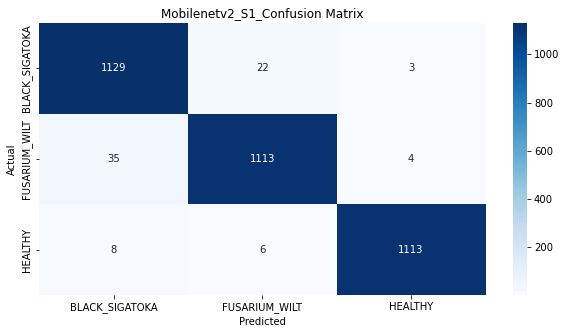

In [21]:
 # Calculate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Create a heatmap with seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Mobilenetv2_S1_Confusion Matrix')
plt.show()

Train and Loss graphs

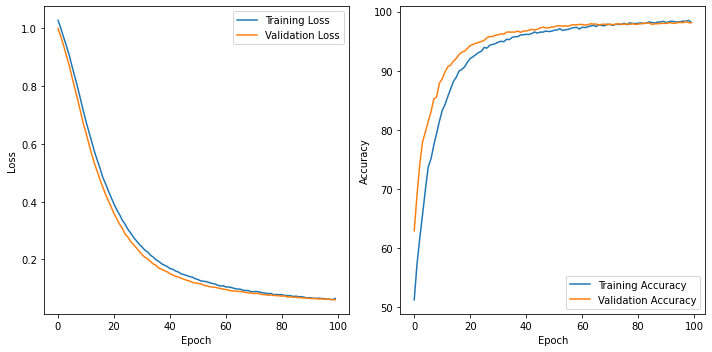

In [19]:
# Plot loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

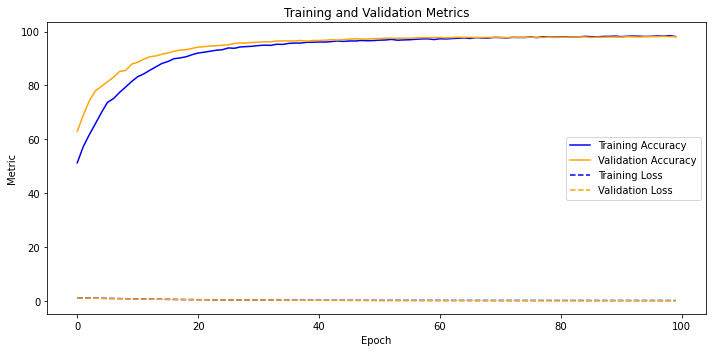

In [20]:
# Plot loss and accuracy graphs on a single set of axes
plt.figure(figsize=(10, 5))

# Plot Accuracy
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(valid_accuracy, label='Validation Accuracy', color='orange')

# Plot Loss
plt.plot(train_losses, label='Training Loss', linestyle='--', color='blue')
plt.plot(valid_losses, label='Validation Loss', linestyle='--', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Training and Validation Metrics')

plt.tight_layout()
plt.show()

# 8. HYPERPARAMETERS RESULTS  ANALYSIS

Plotting sample of domain space

/tmp/ipykernel_65600/3935077121.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);


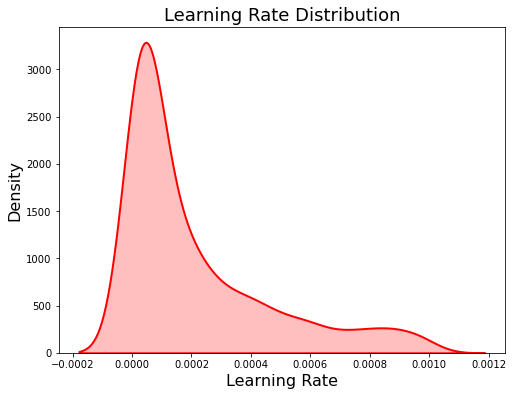

In [39]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.001))}
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(1000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])

plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18);
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

/tmp/ipykernel_65600/556698049.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(momentum_dist, color = 'blue', linewidth = 2, shade = True);


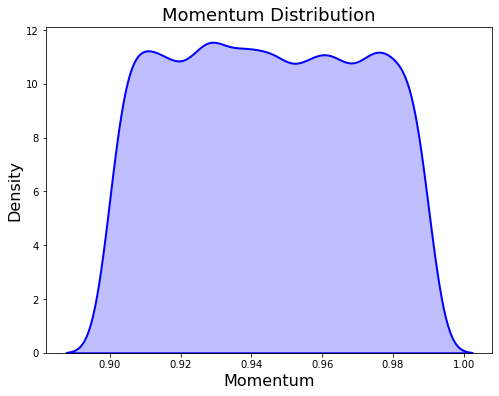

In [40]:
momentum = {'momentum': hp.uniform('momentum', 0.9, 0.99)}
momentum_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    momentum_dist.append(sample(momentum)['momentum'])

plt.figure(figsize = (8, 6))
sns.kdeplot(momentum_dist, color = 'blue', linewidth = 2, shade = True);
plt.title('Momentum Distribution', size = 18);
plt.xlabel('Momentum', size = 16); plt.ylabel('Density', size = 16);

Plotting optimized parameters gainst iteration

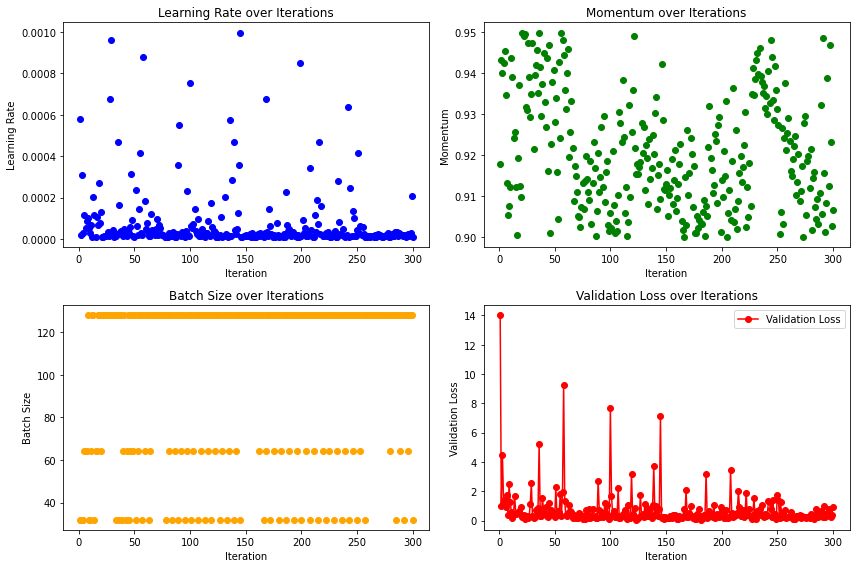

In [36]:
import ast
# Load the optimization results from the CSV file
results_df = pd.read_csv('/home/g6501222802/thesis/results/mobilenetv2_s1_results.csv')

# Convert the 'params' column from string to dictionary
results_df['params'] = results_df['params'].apply(ast.literal_eval)

iterations = np.array(results_df['iterations'])
loss = np.array(results_df['loss'])

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Scatter plot for learning rate
axs[0, 0].scatter(iterations, results_df['params'].apply(lambda x: x['learning_rate']),  color='blue', marker='o', label='Learning Rate')

# Scatter plot for momentum
axs[0, 1].scatter(iterations, results_df['params'].apply(lambda x: x['momentum']),  color='green', marker='o', label='Momentum')

# Scatter plot for batch size
axs[1, 0].scatter(iterations, results_df['params'].apply(lambda x: x['batch_size']),  color='orange', marker='o', label='Batch Size')

# Line chart for objective values (e.g., validation loss) over iterations
axs[1, 1].plot(iterations, loss,  color='red', marker='o', label='Validation Loss')

# Set titles and labels for all subplots
axs[0, 0].set_title('Learning Rate over Iterations')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Learning Rate')

axs[0, 1].set_title('Momentum over Iterations')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Momentum')

axs[1, 0].set_title('Batch Size over Iterations')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Batch Size')

axs[1, 1].set_title('Validation Loss over Iterations')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Validation Loss')

# Display a combined legend for all subplots
plt.legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

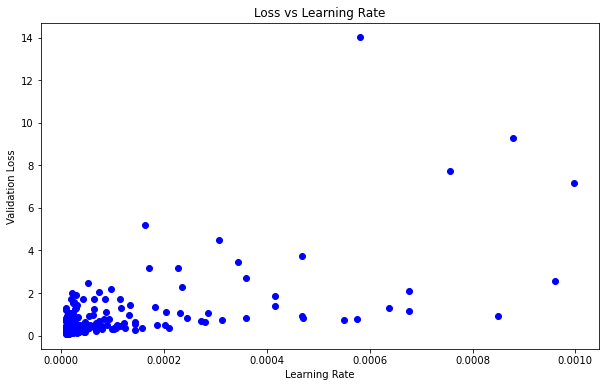

In [37]:
# Load the optimization results from the CSV file
results_df = pd.read_csv('/home/g6501222802/thesis/results/mobilenetv2-s1_results.csv')

# Convert the 'params' column from string to dictionary
results_df['params'] = results_df['params'].apply(ast.literal_eval)

fig, ax1 = plt.subplots(figsize=(10, 6))
# Create a scatter plot for loss against learning_rate
plt.scatter(results_df['params'].apply(lambda x: x['learning_rate']), results_df['loss'], color='blue', marker='o')
plt.title('Loss vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')

# Show the plot
plt.show()

# 9. Model Complexity Check

In [24]:
#COunting the number of parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = mobilenet_v2(pretrained=True)  # Pre-trained Mobilenetv2

total_params, trainable_params = count_parameters(model)
print(f'Total Parameters: {total_params}')
print(f'Trainable Parameters: {trainable_params}')

Total Parameters: 3504872
Trainable Parameters: 3504872


/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
#Model Size Check
def model_size_in_memory(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    size_in_mb = param_size / (1024 ** 2)  # Convert to megabytes
    return size_in_mb

size_in_mb = model_size_in_memory(model)
print(f'Approximate Model Size in Memory: {size_in_mb:.2f} MB')

Approximate Model Size in Memory: 13.37 MB
